In [157]:
##########################################
# Size Portfolio for Common Stocks       #
# Using NYSE Breakpoints                 #
# July 2018                              #                        
# Qingyi (Freda) Song Drechsler          #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
from dateutil.relativedelta import *
from pandas.tseries.offsets import *

In [159]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [160]:
########################
# CRSP Data Collection #
########################
# Code Similar to CRSPMERGE
crsp_m = conn.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd, 
                      a.ret, a.vol, a.shrout, a.prc, a.cfacpr, a.cfacshr
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1991' and '12/31/2018'
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

# change variable format to int
crsp_m[['permno', 'shrcd', 'exchcd']]=crsp_m[['permno', 'shrcd', 'exchcd']].astype(int)
# line up date to end of month
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [161]:
# add delisting return
dlret = conn.raw_sql("""
                     select permno, dlret, dlstdt 
                     from crsp.msedelist
                     """, date_cols=['dlstdt'])
dlret['permno']=dlret['permno'].astype(int)
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

In [162]:
# merge dlret to get total return
crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)
crsp['totret']=(1+crsp['ret'])*(1+crsp['dlret'])-1

In [163]:
# calculate lag size 
crsp['month']=crsp['date'].dt.month
crsp['exchcd']=crsp['exchcd'].abs()
crsp['size']=crsp['prc'].abs()*crsp['shrout']
crsp = crsp.sort_values(['permno', 'date'])
crsp['size_lag'] = crsp.groupby('permno')['size'].shift(1)

# if first month of a permno, size_lag is size/(1+ret)
crsp['size_lag'] = np.where(crsp['size_lag'].isna(), crsp['size']/(1+crsp['ret']), crsp['size_lag'])

In [164]:
############################
# Output Intermediate Data #
############################
# all quarterly observations
q1 = crsp[(crsp['month']==3)|(crsp['month']==6)|(crsp['month']==9)|(crsp['month']==12)]
q1 = q1[['date', 'jdate','permno', 'exchcd', 'size']]

# quarterly NYSE observations
nyse_q = q1[q1['exchcd']==1]

# all monthly observations
m1 = crsp[['date','jdate','permno','size_lag', 'totret']]
m1['port_date']=m1['jdate']+QuarterEnd(-1)

C:\Users\qsong.WHARTON\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [165]:
# Calculate NYSE Decile Break Point
nyse_bp=nyse_q.groupby(['jdate'])['size']\
.describe(percentiles=[0, .1, .2, .3, .4,.5,.6,.7,.8,.9, 1]).reset_index()

nyse_bp=nyse_bp.rename(columns={'0%':'pct0', '10%':'pct10', '20%':'pct20','30%':'pct30', \
                                '40%':'pct40','50%':'pct50','60%':'pct60','70%':'pct70',\
                                '80%':'pct80','90%':'pct90','100%':'pct100'})

nyse_bp = nyse_bp.drop(['count','mean','std','min','max'], axis=1)
nyse_bp['qtrdate'] = nyse_bp['jdate']+QuarterEnd(0)

In [166]:
# assign stocks to portfolios at each quarter end
qtr_decile = pd.merge(q1, nyse_bp, how='left', left_on=['jdate'], right_on=['qtrdate'])
qtr_decile = qtr_decile.drop(['jdate_x','jdate_y'], axis=1)

# function to assign size group
def sizegrp(row):
    if   (row['pct0']<=row['size']<row['pct10']):
        group=1
    elif (row['pct10']<=row['size']<row['pct20']):
        group=2
    elif (row['pct20']<=row['size']<row['pct30']):
        group=3
    elif (row['pct30']<=row['size']<row['pct40']):
        group=4
    elif (row['pct40']<=row['size']<row['pct50']):
        group=5
    elif (row['pct50']<=row['size']<row['pct60']):
        group=6
    elif (row['pct60']<=row['size']<row['pct70']):
        group=7
    elif (row['pct70']<=row['size']<row['pct80']):
        group=8
    elif (row['pct80']<=row['size']<row['pct90']):
        group=9
    elif (row['pct90']<=row['size']<=row['pct100']):
        group=10
    else:
        group=np.nan
    return pd.Series({'permno':row['permno'], 'date':row['date'], 'exchcd':row['exchcd'], \
                      'qtrdate':row['qtrdate'], 'size': row['size'], 'group': group})
        
qtr_decile=qtr_decile.apply(sizegrp, axis=1)

# label NYSE listed stocks
qtr_decile['nyse_listed']=np.where(qtr_decile['exchcd']==1, 'yes', 'no')

In [180]:
# summary table for frequency count
summ_table = qtr_decile.groupby(['qtrdate', 'group','nyse_listed'])['permno'].count().reset_index()
freq_table=pd.pivot_table(summ_table, index=['qtrdate'], values='permno', columns=['nyse_listed','group'])
freq_table.head(10)

nyse_listed    no                                               yes            \
group        1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0 1.0  2.0  3.0    
qtrdate                                                                         
1991-03-31   2735  604  380  204  147   69   60   31   14    5  133  133  133   
1991-06-30   2711  652  393  210  126   78   49   35   13    5  136  135  135   
1991-09-30   2717  623  406  255  132   81   51   37   13    6  136  136  136   
1991-12-31   2638  658  444  237  141   93   40   43   16    7  139  138  138   
1992-03-31   2633  693  351  223  151   87   47   35   16    7  142  141  142   
1992-06-30   2700  711  397  226  132   88   45   34   16    7  145  144  144   
1992-09-30   2709  658  427  229  124   89   42   36   17    7  146  146  146   
1992-12-31   2684  693  438  217  143   90   52   38   17    8  149  148  148   
1993-03-31   2755  743  389  217  120   82   47   44   15    6  151  151  151   
1993-06-30   2742  864  400  225  105   97   46   45   13    8  153  153  153   

nyse_listed                                     
group       4.0  5.0  6.0  7.0  8.0  9.0  10.0  
qtrdate                                         
1991-03-31   133  132  133  133  133  133  133  
1991-06-30   136  135  135  136  135  135  136  
1991-09-30   136  136  136  136  136  136  136  
1991-12-31   139  138  138  139  138  138  139  
1992-03-31   141  141  142  141  142  141  142  
1992-06-30   144  144  144  144  144  144  145  
1992-09-30   145  146  146  145  146  146  146  
1992-12-31   149  148  148  149  148  148  149  
1993-03-31   151  150  151  151  151  151  151  
1993-06-30   152  153  153  152  153  153  153

In [169]:
###########################################
# Establish Size Group for Monthly Record #
###########################################

m_group = pd.merge(m1[['permno','date','totret','size_lag','port_date']], \
                   qtr_decile[['permno','qtrdate','group']], \
                   how='left', left_on=['permno', 'port_date'], right_on=['permno','qtrdate'])
m_group=m_group[m_group['group'].notna()].drop(['qtrdate','port_date'], axis=1)

In [170]:
# Calculate Monthly Weighted Average Returns by Size Group
m_group =m_group.sort_values(['group', 'date'])

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# value-weigthed return
dec_ret=m_group.groupby(['group','date']).\
apply(wavg, 'totret','size_lag').to_frame().reset_index().\
rename(columns={0: 'decile_ret'})

In [171]:
###########################
# Compare with CRSP Index #
# from CRSP MHISTQ        #
###########################
crsp_ix = conn.raw_sql("""
                      select caldt, totret as crsp_ret, prtnam
                      from crsp.mhistq 
                      where prtnam in ('1','2','3','4','5','6','7','8','9','10')
                      and caldt>='01/01/1991'""", date_cols=['caldt'])

crsp_ix['prtnam']=crsp_ix['prtnam'].astype(int)
crsp_ix['group'] = 11-crsp_ix['prtnam']

dec_ret_comp=pd.merge(dec_ret, crsp_ix, how='left', \
                      left_on=['date', 'group'], right_on=['caldt','group'])

###################
# End of Program  #
###################

In [173]:
####################
# Visualization    #
####################

# Plotting the returns by decile
import os
import matplotlib.pyplot as plt
%matplotlib inline

df = dec_ret_comp
df1 = df[df['group']==1]
df2 = df[df['group']==2]
df3 = df[df['group']==3]
df4 = df[df['group']==4]
df5 = df[df['group']==5]
df6 = df[df['group']==6]
df7 = df[df['group']==7]
df8 = df[df['group']==8]
df9 = df[df['group']==9]
df10 = df[df['group']==10]

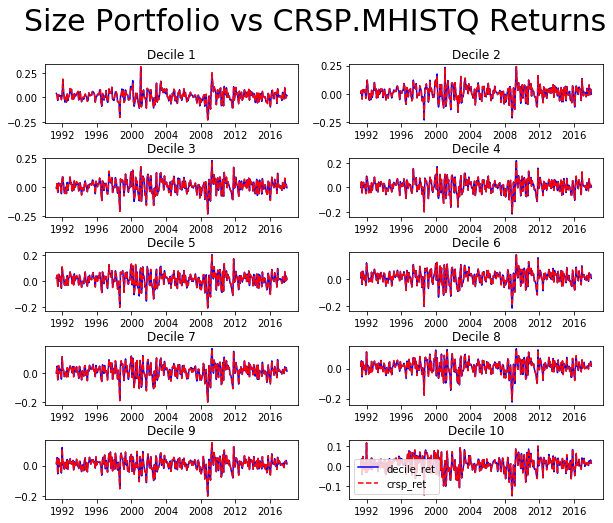

In [182]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(hspace=.6)
plt.suptitle('Size Portfolio vs CRSP.MHISTQ Returns', fontsize=30)

plt.subplot(521)
plt.plot(df1['date'], df1['decile_ret'], 'b', df1['date'], df1['crsp_ret'], 'r--')
plt.title('Decile 1')

plt.subplot(522)
plt.plot(df2['date'], df2['decile_ret'], 'b', df2['date'], df2['crsp_ret'], 'r--')
plt.title('Decile 2')

plt.subplot(523)
plt.plot(df3['date'], df3['decile_ret'], 'b', df3['date'], df3['crsp_ret'], 'r--')
plt.title('Decile 3')

plt.subplot(524)
plt.plot(df4['date'], df4['decile_ret'], 'b', df4['date'], df4['crsp_ret'], 'r--')
plt.title('Decile 4')

plt.subplot(525)
plt.plot(df5['date'], df5['decile_ret'], 'b', df5['date'], df5['crsp_ret'], 'r--')
plt.title('Decile 5')

plt.subplot(526)
plt.plot(df6['date'], df6['decile_ret'], 'b', df6['date'], df6['crsp_ret'], 'r--')
plt.title('Decile 6')

plt.subplot(527)
plt.plot(df7['date'], df7['decile_ret'], 'b', df7['date'], df7['crsp_ret'], 'r--')
plt.title('Decile 7')

plt.subplot(528)
plt.plot(df8['date'], df8['decile_ret'], 'b', df8['date'], df8['crsp_ret'], 'r--')
plt.title('Decile 8')

plt.subplot(529)
plt.plot(df9['date'], df9['decile_ret'], 'b', df9['date'], df9['crsp_ret'], 'r--')
plt.title('Decile 9')

plt.subplot(5,2,10)
plt.plot(df10['date'], df10['decile_ret'], 'b', df10['date'], df10['crsp_ret'], 'r--')
plt.title('Decile 10')

plt.legend(['decile_ret', 'crsp_ret'])
plt.show()

#uncomment and edit these lines to save the png output
#from pathlib import Path
#fig.savefig(os.path.join(Path.home(), '<your_subdirectory>', 'size_port_return.png'))